In [1]:
#!{sys.executable} -m pip install statsmodels 
#!conda install --yes --prefix {sys.prefix} pymysql

import os
import sys
import re
import numpy as np
import pymysql
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import entropy, spearmanr, pearsonr
import pickle 
import math
import pprint
from datetime import datetime
import json
import csv
import pandas as pd
import seaborn as sns
import matplotlib.dates as mdates
from pytz import timezone
#from sklearn.linear_model import LinearRegression
from scipy.spatial import distance
from scipy import stats
from math import pi
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.base.datetools import dates_from_str
import statsmodels.api as sm
base_path = './'
plt.rcParams["font.family"] = "sans"
from scipy.stats import entropy
from scipy.special import binom
from sklearn.linear_model import LinearRegression

#plt.rcParams["font.weight"] = "200"
#plt.rcParams['font.size'] =  11


### Loading News General Data

In [2]:
news_general = pd.DataFrame()
for filename in os.listdir(base_path+"/final_sep_queries_news/"):
    if filename.split(".")[-1] == "pickle" and filename[0:3]=="sep":
        tmp = pd.read_pickle(base_path+"/final_sep_queries_news/"+filename).set_index("date").drop(columns=['count_total_article_each_date'])
        tmp.columns = [c+"_"+filename.split(".")[0].split("_")[-1] for c in tmp.columns]
        news_general = pd.concat([news_general,tmp],axis=1)
        n_kw = [c.split("_")[1] for c in tmp.columns]
suffixes = ["tutto","1","3"]
suff_trans = {"1":"$\geq$1 occurrence", "3":"$\geq$3 occurrences", "tutto":"Average occurrences"}
linest =  {"1":"--", "3":":", "tutto":"-"}
lineco =  {"1":"cornflowerblue", "3":"b", "tutto":"royalblue"}


### Loading Searches General Data

In [3]:
search_general = pd.read_csv(base_path+"interest_over_time_sep_queries.csv",index_col=0)

search_general = search_general/100
search_general.index = pd.to_datetime(search_general.index)
search_general.index = pd.DatetimeIndex(search_general.index,freq=search_general.index.inferred_freq)
search_general = search_general.drop(columns=["papa","viviana"])

s_kw = list(search_general.columns)

search_general.columns = ["s_"+c for c in search_general.columns]

### Loading Fake News General Data

In [4]:
fake_data = pd.read_pickle(base_path+"final_sep_queries_news/coronavirus&fake&related.pickle").set_index("date")
fdata = pd.DataFrame()
fdata = pd.concat([fdata,(fake_data["count_article_each_date_coronavirus_fake"]/fake_data["count_article_each_date_coronavirus"]).dropna()],axis=1).rename(columns = {0:'fc/c'})
fdata = pd.concat([fdata,(fake_data["count_article_each_date_coronavirus_fake"]/fake_data["count_article_each_date_fake"]).dropna()],axis=1,join="inner").rename(columns = {0:'fc/f'})
fdata = pd.concat([fdata,(fake_data["count_article_each_date_coronavirus_fake"]/fake_data["count_article_each_date"]).dropna()],axis=1,join="inner").rename(columns = {0:'fc/all'})
fdata = pd.concat([fdata,(fake_data["count_article_each_date_fake"]/fake_data["count_article_each_date"]).dropna()],axis=1,join="inner").rename(columns = {0:'f/all'})


### Keywords check and merge


In [5]:
n_kw == s_kw
print("Broad List")
print(n_kw)
general = pd.concat([search_general,news_general],axis=1)

kw_list = [kw for kw in n_kw if kw not in ["viviana parisi","gioele"]]

Broad List
['coronavirus', 'sanremo', 'elezioni', 'regionali', 'calcio', 'campionato', 'champions', 'serie a', 'eurovision', 'morricone', 'meteo', 'papa francesco', 'beirut', 'viviana parisi', 'gioele', 'ps5', 'playstation', 'lotto', 'roma', 'sondaggi']


### News and Searches graphs

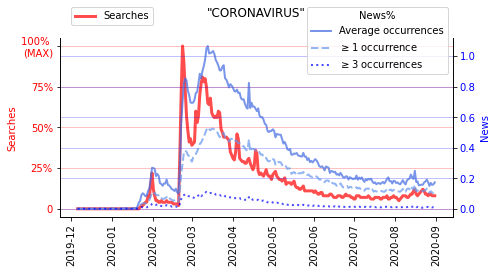

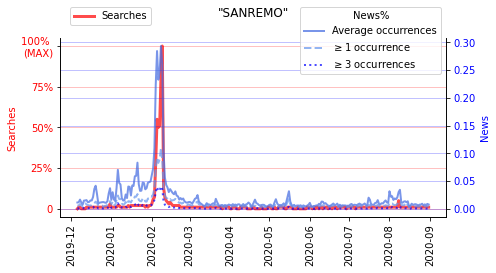

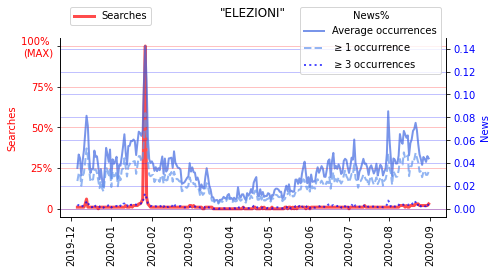

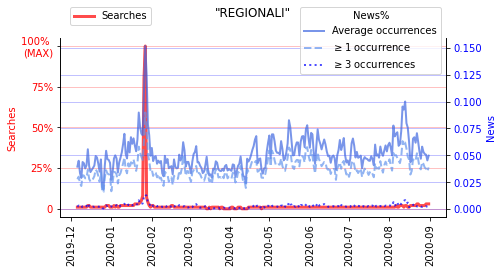

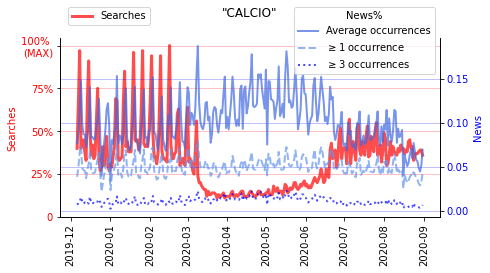

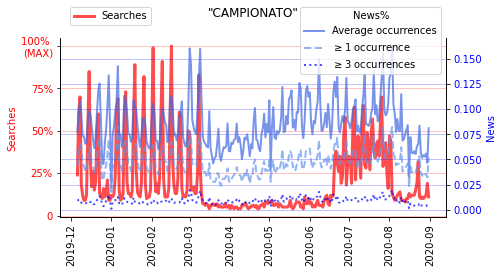

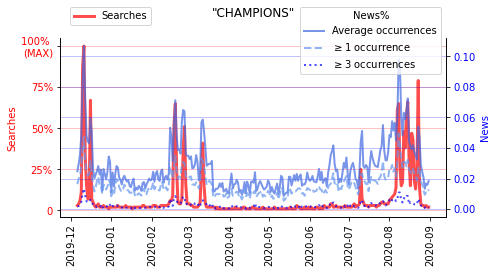

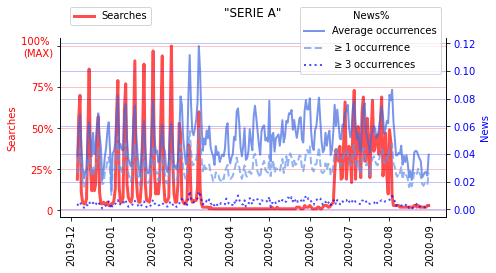

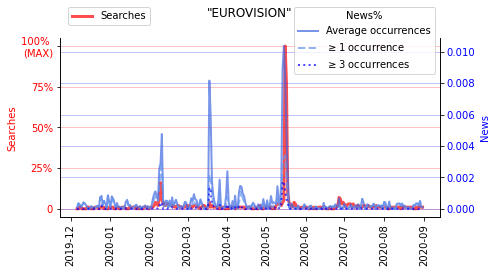

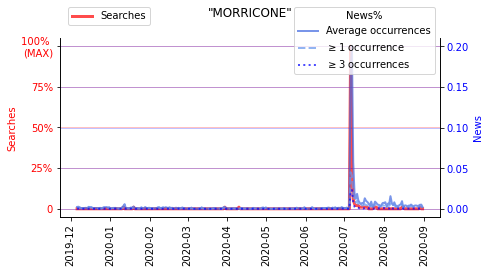

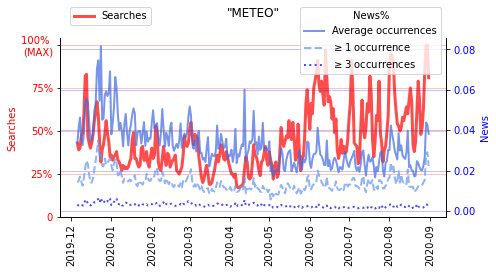

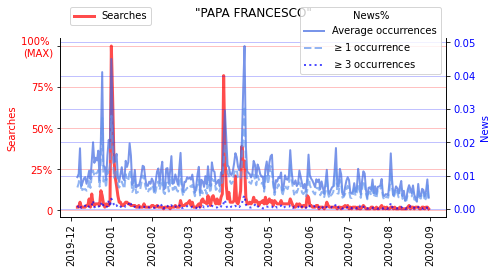

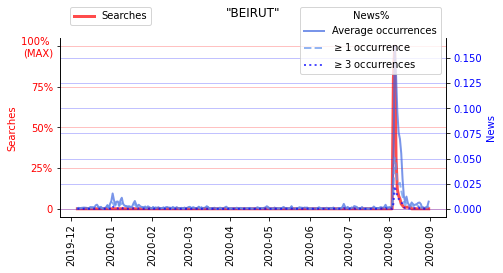

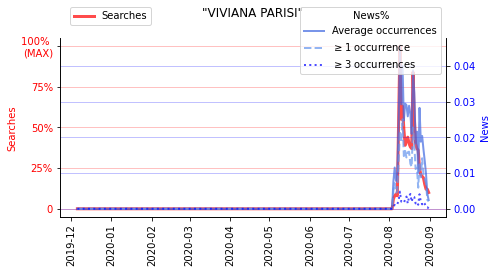

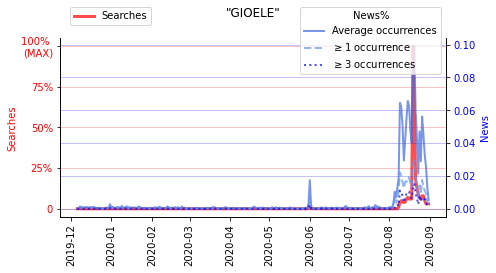

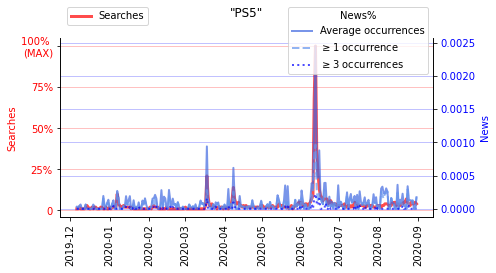

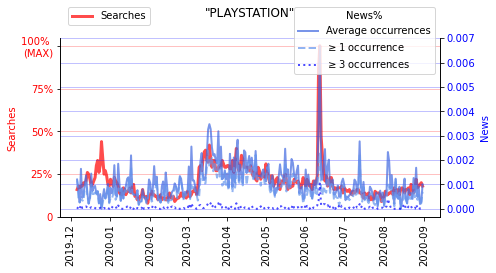

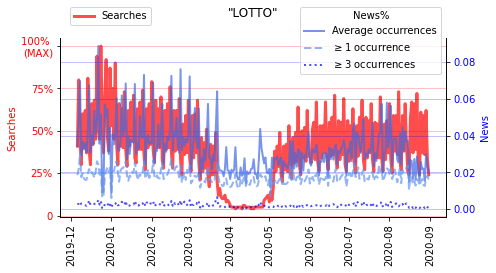

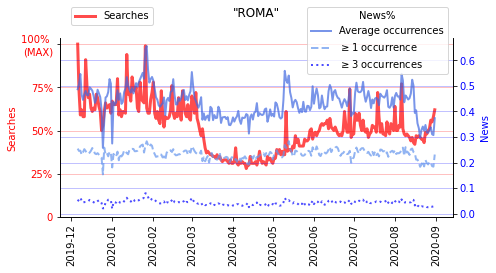

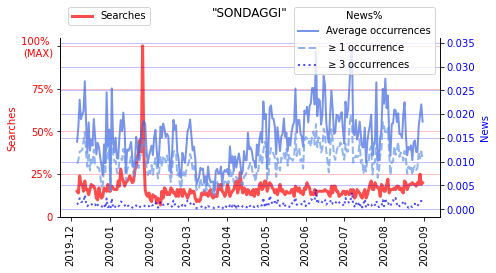

In [6]:

for kw in n_kw:
#    plt.figure(figsize=[8,6])
    fig, ax1 = plt.subplots(figsize=[7,4])
    ax1.plot(general["s_"+kw], label="Searches", color="red",lw=3,alpha=.7)
    ax1.set_ylabel('Searches', color="red" )
    ax1.set(yticks=[0,.25,.50,.75,1], yticklabels=["0","25%", "50%","75%","100% \n(MAX)"],)
    ax1.tick_params(axis='y', labelcolor="red")
    ax1.tick_params(axis='x', rotation=90)
#    ax1.set_xticklabels(rotation=90)
    plt.legend(bbox_to_anchor=(.25, 1.2))
    ax1.yaxis.grid(color="red", alpha=.3)
    ax2 = ax1.twinx() 
#    ax2.set(yticks=[0,.25,.50,.75,1], yticklabels=["0","25%", "50%","75%","100%"],)
    ax2.tick_params(axis='y', labelcolor="blue")
    ax2.set_ylabel('News', color="Blue" )
    
    for suff in suffixes:
        ax2.plot(general["n_"+kw+"_"+suff], color=lineco[suff],lw=2,alpha=.7, ls=linest[suff],label= suff_trans[suff])
    ax2.legend(bbox_to_anchor=(1.0, 1.2),title="News%",loc=1)
    plt.grid(color="blue", alpha=.3)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title("\""+kw.upper()+"\"\n")
    sns.despine(fig=fig,right=False)
    plt.savefig(kw+".pdf")
    plt.show()

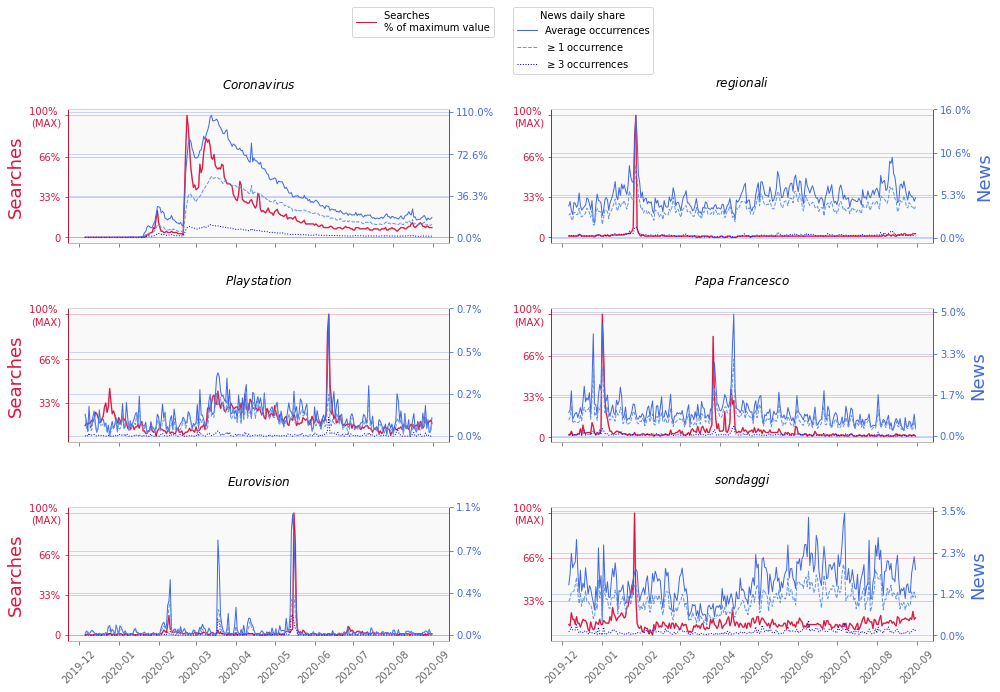

In [7]:
#large_good_kw = ["coronavirus", "elezioni", "regionali", "ps5","playstation","papa francesco", "eurovision",  "sondaggi"]
nrow = 3
ncol = 2

large_good_kw = ["coronavirus", "regionali","playstation","papa francesco", "eurovision",  "sondaggi"]
titles = {"coronavirus":"Coronavirus", "regionali":"regionali","playstation":"Playstation","papa francesco":"Papa Francesco", "eurovision":"Eurovision",  "sondaggi":"sondaggi"}
maxes = {"coronavirus":110, "regionali":16,"playstation":.70,"papa francesco":5, "eurovision": 1.10,  "sondaggi":3.50}
fig, axs = plt.subplots(nrow,ncol, sharex=True, figsize=[14,10],facecolor="white")

for i, kw in enumerate(large_good_kw):
#    plt.figure(figsize=[8,6])
#    fig, ax1 = plt.subplots(figsize=[7,4])
    axs[int(i/ncol)][i%ncol].plot(general["s_"+kw]*100, label="Searches \n% of maximum value", color="crimson",lw=1.)
    if i%2 == 0:
        if i % 2 == 0:
            axs[int(i/ncol)][i%ncol].set_ylabel('Searches', color="crimson", fontsize=18)
    axs[int(i/ncol)][i%ncol].set(yticks=[0,33,66,100], yticklabels=["0","33%", "66%","100% \n(MAX)"],)
    axs[int(i/ncol)][i%ncol].tick_params(axis='y', labelcolor="crimson" )
    axs[int(i/ncol)][i%ncol].tick_params(axis='x', rotation=45, labelcolor="#333")
#    ax1.set_xticklabels(rotation=90)
    if i == 0:
        axs[int(i/ncol)][i%ncol].legend(bbox_to_anchor=(1.13, 1.8))
    axs[int(i/ncol)][i%ncol].yaxis.grid(color="crimson", alpha=.3)
#    axs[int(i/ncol)][i%ncol].set_yscale('log')

    ax2 = axs[int(i/ncol)][i%ncol].twinx() 
#    ax2.set(yticks=[0,.25,.50,.75,1], yticklabels=["0","25%", "50%","75%","100%"],)
    ax2.tick_params(axis='y', labelcolor="royalblue")
    if i%2 == 1:
        ax2.set_ylabel('News', color="royalblue", fontsize=18)
#    ax2.set_yscale('log')
    for suff in suffixes:
        ax2.plot(general["n_"+kw+"_"+suff]*100, color=lineco[suff],lw=1, ls=linest[suff],label= suff_trans[suff])
#    ax2.set(yticklabels=["%2.1f"%s + "%" for s in ax2.get_yticks()])
    max_ra = maxes[kw]
    yt = [0,.33*max_ra,.66*max_ra,1*max_ra]
    ytl = ["%2.1f"%f + "%" for f in yt]
    ax2.set(yticks=yt, yticklabels=ytl,)
    if i == 1:
        ax2.legend(bbox_to_anchor=(.28, 1.80),title="News daily share",loc=1)
    ax2.grid(color="royalblue", alpha=.3)
    axs[int(i/ncol)][i%ncol].set_title("\n$"+"$ $".join(titles[kw].split())+"$\n")
#    sns.despine(fig=fig,right=False)
    axs[int(i/ncol)][i%ncol].set_facecolor('#f9f9f9')
    ax2.spines['bottom'].set_color('#ddd')
    ax2.spines['top'].set_color('#fff') 
    ax2.spines['right'].set_color('royalblue')
    ax2.spines['left'].set_color('crimson')
    axs[int(i/ncol)][i%ncol].tick_params(axis='x', colors='#666')
    axs[int(i/ncol)][i%ncol].tick_params(axis='y', colors='crimson')
    ax2.tick_params(axis='y', colors='royalblue')
    axs[int(i/ncol)][i%ncol].plot(general["s_"+kw]*100, color="crimson",alpha=.5)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig("desc.pdf")
plt.show()

### VAR & Granger Causality

In [8]:
dt = 14
best_model_d = {}
best_model_c_s2n = {}
best_model_c_n2s = {}
for kw in large_good_kw:
    for suff in ["3"]:#suffixes:
        min_aic = 1000
        mdata = general[["s_"+kw,"n_"+kw+"_"+suff]]
        for d in range(1,dt):
            data = np.log(mdata+1).dropna()
            model = VAR(data)
            results = model.fit(d)
            if results.aic < min_aic:
                min_aic = results.aic
                best_model_d[kw] = d
                best_model_c_s2n[kw] = results.test_causality("n_"+kw+"_"+suff, ["s_"+kw], kind='f')
                best_model_c_n2s[kw] = results.test_causality("s_"+kw, ["n_"+kw+"_"+suff], kind='f')
#        plt.plot(range(1,dt),tmp,label=suff)
#    plt.legend()
#    plt.show()
    


### Causality test Holm-Bonferroni

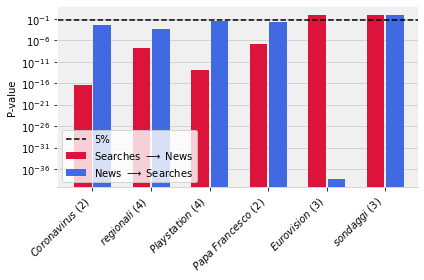

In [9]:
x = np.arange(len(large_good_kw))  # the label locations
width = 0.30  # the width of the bars

fig, ax = plt.subplots(figsize=[6,4],facecolor="white")
ax.yaxis.grid(color="#ccc")
ax.set_axisbelow(True)
ax.set_facecolor('#f0f0f0')
ax.spines['bottom'].set_color('#ccc') 
ax.spines['top'].set_color('#fff') 
ax.spines['left'].set_color('#fff') 
ax.spines['right'].set_color('#fff') 
ax.plot([-1,len(large_good_kw)],[.05]*2,"--",color = "black",label="5%")
plt.xlim([0-2*width,len(large_good_kw)-1.5*width])
ax.bar(x - width/1.8, [min(1,best_model_c_s2n[kw].pvalue*2) for kw in large_good_kw], width=width, label='Searches $ \longrightarrow $ News', color="crimson")
ax.bar(x + width/1.8, [min(1,best_model_c_n2s[kw].pvalue*2) for kw in large_good_kw], width=width, label='News $ \longrightarrow $ Searches', color="royalblue")
ax.set_xticks(x)
ax.set_ylabel("P-value")
ax.set_yscale("log")
ax.set_xticklabels(["$"+"$ $".join(titles[kw].split())+"$" + ' (' +str(best_model_d[kw])+')' for kw in large_good_kw], rotation=45,ha="right")

plt.legend(loc=3)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig("causality.pdf")

plt.show()

### Utility Functions

In [10]:
def reg_aic2(X,y):
    ols = sm.OLS(y, X)
    ols_result = ols.fit()
#    print(ols_result.summary())
    return ols_result.aic,ols_result.rsquared_adj,ols_result.params,ols_result.conf_int(),ols_result.predict(X),ols_result.pvalues


def comparer2(n,s,delta=1,pres=True):
    ds = []
    ks = []
    aics = []
    ar2s = []
    coeffs = []
    errs = []
    preds = []
    pvals = []
    for d in range(delta):
        for k in range(delta):
            X = []
            starter = max(d,k)
            for i in range(starter,len(s)):
                if pres:
                    vect = [s[i]]
                else:
                    vect = []
                for ki in range(k):
                    vect.append(n[i-ki-1])
                for di in range(d):
                    vect.append(s[i-di-1])
                vect = np.array(vect)
                X.append(vect)
            X = np.array(X)
            if len(X[0]) > 0:
                aic,ar2,params,param_errs,predictions,pv = reg_aic2(X,n[starter:])
                aics.append(aic)
                ar2s.append(ar2)
                ds.append(d)
                ks.append(k)
                coeffs.append(params)
                errs.append(param_errs)
                preds.append(predictions)
                pvals.append(pv)
    return pd.DataFrame({'d_s':ds, 'k_n':ks, 'aic':aics,'ar2':ar2s, 'coeffs':coeffs,'coeffs':coeffs, 'errs':errs,'preds':preds,'pvals':pvals})

def cycler(searches,news,delta=40,lab=""):
    data = {}
    data["Raw"] = {}
    data["Log"] = {}
    data["DiffLog"] = {}
    data["Raw"]["s"] = np.array(searches)
    data["Raw"]["n"] = np.array(news)
    data["Log"]["s"] = np.log(data["Raw"]["s"]+1)
    data["Log"]["n"] = np.log(data["Raw"]["n"]+1)
    data["DiffLog"]["s"] = np.diff(data["Log"]["s"])
    data["DiffLog"]["n"] = np.diff(data["Log"]["n"])
    vals = [True, False]
    res = pd.DataFrame()
#    print("Calculating ...")
    for key in ["Log"]:#data:
        for val in vals:
#            print("\t",key,val)
            tmp = comparer2(data[key]["n"],data[key]["s"],delta,val)
            tmp["label"] = key+"_"+str(delta)+"_"+str(val)+"_"+lab
            res = pd.concat([res,tmp])
    return res


In [11]:
good_kw = ["coronavirus", "regionali","playstation","papa francesco"]


In [12]:
best_model_params = {}
best_model_pvals = {}
best_model_r2 = {}
delta_s = {}
delta_n = {}
for kw in good_kw:
#    print("#################")
#    print(kw)
#    print("#################")
    for suff in ["3"]:
        s = general["s_"+kw]
        n = general["n_"+kw+"_"+suff]
        res = cycler(s,n,delta=14,lab=suff)
#        print(res[res.aic == res.aic.min()])
#        print(list(res[res.aic == res.aic.min()]["pvals"]))
        best_model_params[kw] = list(res[res.aic == res.aic.min()]["coeffs"])
        delta_s[kw] = int(res[res.aic == res.aic.min()]["d_s"])
        delta_n[kw] = int(res[res.aic == res.aic.min()]["k_n"])
        best_model_r2[kw] = res[res.aic == res.aic.min()]["ar2"]
        best_model_pvals[kw] = list(res[res.aic == res.aic.min()]["pvals"])[0]

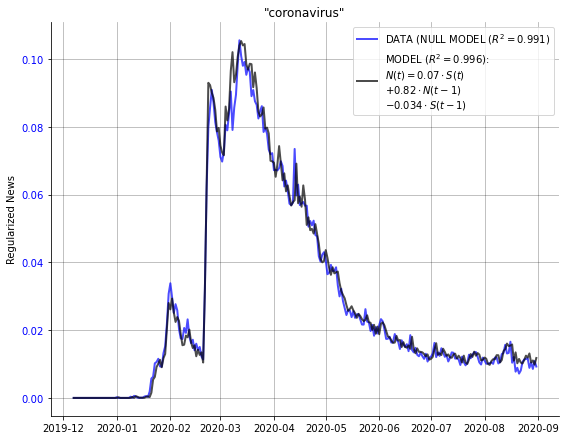

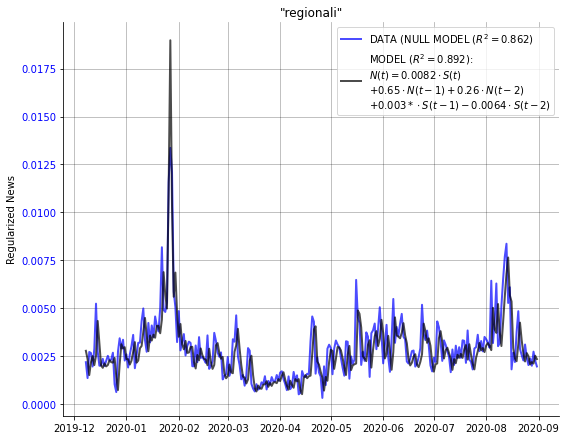

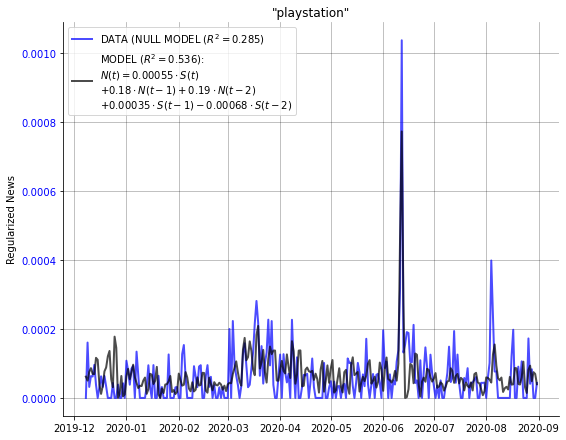

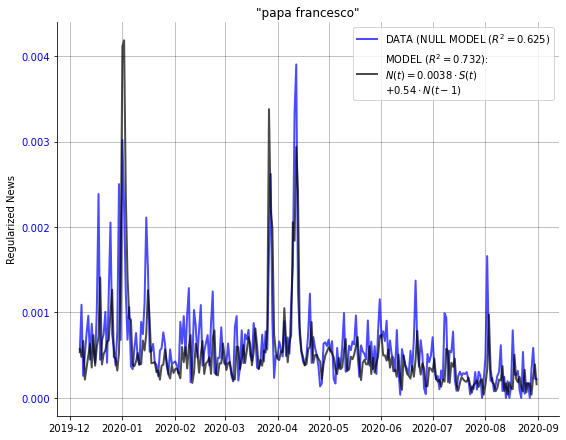

In [13]:
for kw in best_model_params:
    s = general["s_"+kw]
    n = general["n_"+kw+"_"+suff]
    preds = []
    for i in range(max(delta_n[kw],delta_s[kw]),len(s)):
        vect = [s[i]]
        for ki in range(delta_n[kw]):
            vect.append(n[i-ki-1])
        for di in range(delta_s[kw]):
            vect.append(s[i-di-1])    
        vect = np.array(vect)
        preds.append(np.dot(vect,best_model_params[kw][0]))
    preds = np.array(preds)
    
    i = 0
    if best_model_pvals[kw][i] > .05:
        formula = "$N(t) = %.2g* \cdot S(t) " % best_model_params[kw][0][i]
    else:
        formula = "$N(t) = %.2g \cdot S(t) " % best_model_params[kw][0][i]
    i+=1
    formula += "$\n$"
    for ki in range(delta_n[kw]):
        if best_model_pvals[kw][i] > .05:
            formula += "%+.2g* \cdot N(t - %d) " % (best_model_params[kw][0][i],ki+1)
        else:
            formula += "%+.2g \cdot N(t - %d) " % (best_model_params[kw][0][i],ki+1)
        i+=1
    if delta_s[kw]:
        formula += "$\n$"
        for di in range(delta_s[kw]):
            if best_model_pvals[kw][i] > .05:
                formula += "%+.2g* \cdot S(t - %d) " % (best_model_params[kw][0][i],di+1)
            else:
                formula += "%+.2g \cdot S(t - %d) " % (best_model_params[kw][0][i],di+1)
            i+=1
    formula += "$"
    ols = sm.OLS(list(np.log(1+n[1:])), list(np.log(n[:-1]+1)))
    ols_result = ols.fit()
    null_model_r2 = ols_result.rsquared_adj
    fig, ax1 = plt.subplots(figsize=[8,6])
    ax1.plot(np.log(1+n[max(delta_n[kw],delta_s[kw]):]), label="DATA (NULL MODEL $(R^2 = %.3g)$" % null_model_r2, color="blue",lw=2,alpha=.7)
    ax1.plot(n[max(delta_n[kw],delta_s[kw]):].index,np.log(1+np.array([0 if x < 0 else x for x in preds ])), label="MODEL $(R^2 = %.3g)$:\n" % best_model_r2[kw] +formula, color="black",lw=2,alpha=.7)
    ax1.set_ylabel('Regularized News')
    ax1.tick_params(axis='y', labelcolor="blue")
    plt.legend()
    ax1.grid(color="black", alpha=.3)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title("\""+kw+"\"")
    sns.despine()
    plt.show()

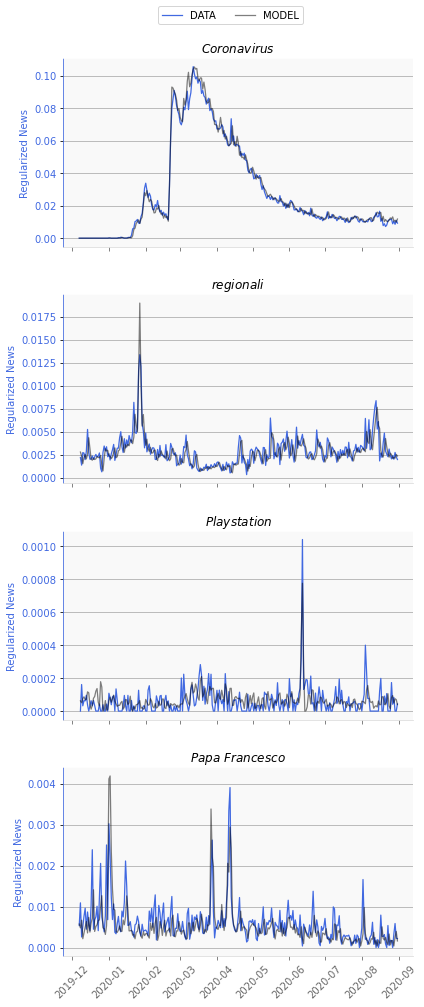

In [14]:
#fig, axs = plt.subplots(nrow,ncol, sharex=True, figsize=[14,10])
nrow = 4
ncol = 2

fig, axs = plt.subplots(nrow, sharex=True, figsize=[6,14])

for enu, kw in enumerate(list(best_model_params.keys())):
    s = general["s_"+kw]
    n = general["n_"+kw+"_"+suff]
    preds = []
    for i in range(max(delta_n[kw],delta_s[kw]),len(s)):
        vect = [s[i]]
        for ki in range(delta_n[kw]):
            vect.append(n[i-ki-1])
        for di in range(delta_s[kw]):
            vect.append(s[i-di-1])    
        vect = np.array(vect)
        preds.append(np.dot(vect,best_model_params[kw][0]))
    preds = np.array(preds)
    
    i = 0
    if best_model_pvals[kw][i] > .05:
        formula = "$N(t) = %.2g* \cdot S(t) " % best_model_params[kw][0][i]
    else:
        formula = "$N(t) = %.2g \cdot S(t) " % best_model_params[kw][0][i]
    i+=1
    formula += "$\n$"
    for ki in range(delta_n[kw]):
        if best_model_pvals[kw][i] > .05:
            formula += "%+.2g* \cdot N(t - %d) " % (best_model_params[kw][0][i],ki+1)
        else:
            formula += "%+.2g \cdot N(t - %d) " % (best_model_params[kw][0][i],ki+1)
        i+=1
    if delta_s[kw]:
        formula += "$\n$"
        for di in range(delta_s[kw]):
            if best_model_pvals[kw][i] > .05:
                formula += "%+.2g* \cdot S(t - %d) " % (best_model_params[kw][0][i],di+1)
            else:
                formula += "%+.2g \cdot S(t - %d) " % (best_model_params[kw][0][i],di+1)
            i+=1
    formula += "$"
    ols = sm.OLS(list(np.log(1+n[1:])), list(np.log(n[:-1]+1)))
    ols_result = ols.fit()
    null_model_r2 = ols_result.rsquared_adj

#    ax1 = axs[int(enu/ncol)][enu%ncol]
    ax1 = axs[enu]

#    ax1.plot(np.log(1+n[max(delta_n[kw],delta_s[kw]):]), label="DATA \n(NULL MODEL $R^2 = %.3g)$" % null_model_r2, color="blue",lw=2,alpha=.7)
#    ax1.plot(n[max(delta_n[kw],delta_s[kw]):].index,np.log(1+np.array([0 if x < 0 else x for x in preds ])), label="MODEL $(R^2 = %.3g)$:\n" % best_model_r2[kw] +formula, color="black",lw=2,alpha=.7)
    ax1.plot(np.log(1+n[max(delta_n[kw],delta_s[kw]):]), label="DATA", color="royalblue",lw=1.25)
    ax1.plot(n[max(delta_n[kw],delta_s[kw]):].index,np.log(1+np.array([0 if x < 0 else x for x in preds ])), label="MODEL", color="black",lw=1.25,alpha=.5)
    ax1.set_ylabel('Regularized News', color="royalblue")
    ax1.tick_params(axis='y', labelcolor="royalblue")
    if enu == 0:
        ax1.legend(bbox_to_anchor=(.7, 1.3),ncol=2)
        
    ax1.grid(color="black", axis='y', alpha=.3)
    ax1.tick_params(axis='x', rotation=45)
    ax1.set_title("\n$"+"$ $".join(titles[kw].split())+"$")
#    sns.despine()
    ax1.set_facecolor('#f9f9f9')
    ax1.spines['bottom'].set_color('#ddd')
    ax1.spines['top'].set_color('#fff') 
    ax1.spines['left'].set_color('royalblue')
    ax1.spines['right'].set_color('#fff')
    ax1.tick_params(axis='x', colors='#666')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig("models.pdf")
plt.show()

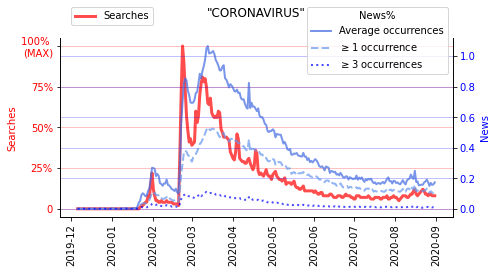

In [15]:
kw = "coronavirus"
fig, ax1 = plt.subplots(figsize=[7,4])
ax1.plot(general["s_"+kw], label="Searches", color="red",lw=3,alpha=.7)
ax1.set_ylabel('Searches', color="red" )
ax1.set(yticks=[0,.25,.50,.75,1], yticklabels=["0","25%", "50%","75%","100% \n(MAX)"],)
ax1.tick_params(axis='y', labelcolor="red")
ax1.tick_params(axis='x', rotation=90)
#    ax1.set_xticklabels(rotation=90)
plt.legend(bbox_to_anchor=(.25, 1.2))
ax1.yaxis.grid(color="red", alpha=.3)
ax2 = ax1.twinx() 
#    ax2.set(yticks=[0,.25,.50,.75,1], yticklabels=["0","25%", "50%","75%","100%"],)
ax2.tick_params(axis='y', labelcolor="blue")
ax2.set_ylabel('News', color="Blue" )
    
for suff in suffixes:
    ax2.plot(general["n_"+kw+"_"+suff], color=lineco[suff],lw=2,alpha=.7, ls=linest[suff],label= suff_trans[suff])
ax2.legend(bbox_to_anchor=(1.0, 1.2),title="News%",loc=1)
plt.grid(color="blue", alpha=.3)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("\""+kw.upper()+"\"\n")
sns.despine(fig=fig,right=False)
plt.savefig(kw+".pdf")
plt.show()

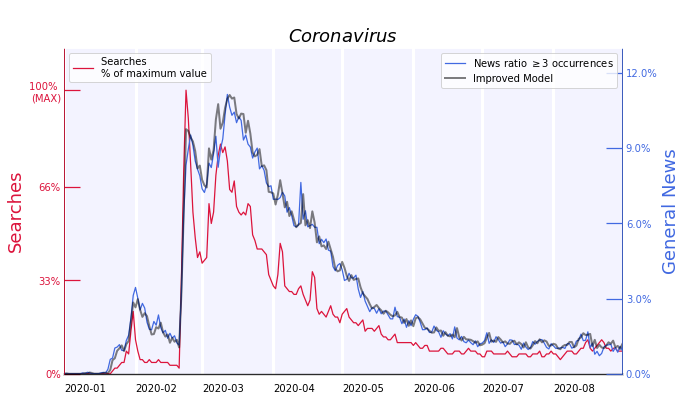

In [16]:

col_s = "crimson"
col_n = "royalblue"


fig, ax1 = plt.subplots(sharex=True, figsize=[10,6])

kw = "coronavirus"    
s = general["s_"+kw]
n = general["n_"+kw+"_3"]
preds = []
for i in range(max(delta_n[kw],delta_s[kw]),len(s)):
    vect = [s[i]]
    for ki in range(delta_n[kw]):
        vect.append(n[i-ki-1])
    for di in range(delta_s[kw]):
        vect.append(s[i-di-1])    
    vect = np.array(vect)
    preds.append(np.dot(vect,best_model_params[kw][0]))
preds = np.array(preds)

ax2 = ax1.twinx() 


#ax1.plot(general["s_"+kw], label="Searches", color="red",lw=3,alpha=.7)
ax1.plot(general["s_"+kw]*100, label="Searches \n% of maximum value", color=col_s,lw=1.25)
ax1.set_ylabel('Searches', color=col_s, fontsize=18)
ax1.set(yticks=[0,33,66,100], yticklabels=["0%","33%", "66%","100% \n(MAX)"],)
ax1.tick_params(axis='y', labelcolor=col_s )
ax1.tick_params(axis='x', rotation=0, labelcolor="black",pad=10)
ax1.legend(loc=2)

ax1.set_ylim([0,115])
ax2.set_ylim([0,.13])
ax1.set_xlim([n[max(delta_n[kw],delta_s[kw]):].index[25],n[max(delta_n[kw],delta_s[kw]):].index[-1]])


ax2.plot(n[max(delta_n[kw],delta_s[kw]):], label="News ratio $\geq$3 occurrences", color=col_n,lw=1.25)
#ax2.plot(n[max(delta_n[kw],delta_s[kw]):].index,np.array([0 if x < 0 else x for x in preds ]), color="white",lw=2,alpha=.75)
ax2.plot(n[max(delta_n[kw],delta_s[kw]):].index,np.array([0 if x < 0 else x for x in preds ]), label="Improved Model", color="black",lw=2,alpha=.5)
ax2.set_ylabel('General News', color=col_n, fontsize=18)
ax2.tick_params(axis='y', labelcolor=col_n)
ax2.legend(ncol=1)
    
ax2.set_title("\n$"+"$ $".join(titles[kw].split())+"$", fontsize=18)
ax2.spines['bottom'].set_color('#000')
ax2.spines['bottom'].set_alpha(.15)
ax2.spines['bottom'].set_linewidth(3)
ax1.spines['top'].set_color('#fff')
ax2.spines['top'].set_color('#fff') 
ax2.spines['right'].set_color(col_n)
ax2.spines['left'].set_color(col_s)
#ax2.tick_params(axis='x', colors='#666')
yt = [0,.03,.06,.09, .12]
ytl = ["%2.1f"%(100*f) + "%" for f in yt]


ax2.set(yticks=yt, yticklabels=ytl)
ax1.tick_params(direction='in', length=16, colors=col_s,axis='y',width=1.25)
ax2.tick_params(direction='in', length=16, colors=col_n,axis='y',width=1.25)
ax1.tick_params(direction='inout', length=0, colors='black',axis='x',width=1.5)
#fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax1.set_facecolor('#f3f3ff')
ax1.grid(axis="x", color="#fff",lw=3)
#ax1.imshow([[1,-1],[1,-1]], cmap=plt.cm.bwr, interpolation='quadric', transform=ax1.transAxes, extent=[0,1,0.15,1], vmin=-5, vmax=5)

#xtl = []
#for x in ax1.get_xticklabels():
#    print(x.get_text())
#    xtl.append("     "+x.get_text())
#
#ax1.set(xticklabels=xtl)

for label in ax1.get_xticklabels():
    label.set_horizontalalignment('left')
plt.savefig("img1.pdf")
plt.show()

### The model and the Fake News 

In [17]:
data_ff = pd.concat([general["n_coronavirus_3"],general["n_coronavirus_3"].shift(1),general["s_coronavirus"],general["s_coronavirus"].shift(1)],axis=1).dropna()
data_ff.columns = ["n","n-1","s","s-1"]

data_fffake = pd.concat([fdata["fc/f"],fdata["fc/f"].shift(1),fdata["fc/c"],fdata["fc/c"].shift(1),fdata["fc/all"],fdata["fc/all"].shift(1),data_ff],axis=1).dropna()
data_fffake.columns = ["ffn","ffn-1","fcn","fcn-1","fcan","fcan-1","n","n-1","s","s-1"]


ns_fit_res = sm.OLS(data_fffake["n"].values, data_fffake[["n-1","s","s-1"]].values).fit()
ffns_fit_res = sm.OLS(data_fffake["ffn"].values, data_fffake[["ffn-1","s","s-1"]].values).fit()
fcns_fit_res = sm.OLS(data_fffake["fcn"].values, data_fffake[["fcn-1","s","s-1"]].values).fit()
fcans_fit_res = sm.OLS(data_fffake["fcan"].values, data_fffake[["fcan-1","s","s-1"]].values).fit()
#data_fffake

mn = data_fffake["n"].max()
mfn = data_fffake["fcan"].max()

tmp1 = data_fffake[["n-1","s","s-1"]].copy()
tmp1["n-1"] = tmp1["n-1"]/mn 

tmp2 = data_fffake[["fcan-1","s","s-1"]].copy()
tmp2["fcan-1"] = tmp2["fcan-1"]/mfn 


### Searches, News and Fake News Causality

In [18]:
data_tmp = np.log(data_fffake[["s","n","fcan"]] +1)
data_tmp.index = pd.to_datetime(data_tmp.index)
data_tmp.index = pd.DatetimeIndex(data_tmp.index,freq=data_tmp.index.inferred_freq)
model = VAR(data_tmp)
results = model.fit(1)
#print(results.summary())
print("!f->n",results.test_causality("n",["fcan"], kind='f').pvalue*6)
print("!n<-f",results.test_causality("fcan",["n"], kind='f').pvalue*6)
print("!f->s",results.test_causality("s",["fcan"], kind='f').pvalue*6)
print("!s->f",results.test_causality("fcan",["s"], kind='f').pvalue*6)
print("!s->n",results.test_causality("n",["s"], kind='f').pvalue*6)
print("!n->s",results.test_causality("s",["n"], kind='f').pvalue*6)
print(results.test_causality("s",["n"], kind='f'))

!f->n 0.39236863760180296
!n<-f 0.06541803616738344
!f->s 3.2923883905979827
!s->f 0.06535398664713205
!s->n 5.3107685056899104e-12
!n->s 3.9816062452671273
<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: n does not Granger-cause s: fail to reject at 5% significance level. Test statistic: 0.189, critical value: 3.854>, p-value: 0.664>


/Users/pietro/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


### Modeling Corona News and Fake News: parameters and $R^2$

In [19]:
norm_ns_fit_res = sm.OLS((data_fffake["n"]/mn).values, tmp1.values).fit()
norm_fcans_fit_res = sm.OLS((data_fffake["fcan"]/mfn).values, tmp2.values).fit()

print(norm_ns_fit_res.summary2())
print(norm_fcans_fit_res.summary2())


                        Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.995     
Dependent Variable:     y                AIC:                         -1064.3054
Date:                   2021-06-03 15:47 BIC:                         -1053.8139
No. Observations:       244              Log-Likelihood:              535.15    
Df Model:               3                F-statistic:                 1.703e+04 
Df Residuals:           241              Prob (F-statistic):          3.27e-280 
R-squared (uncentered): 0.995            Scale:                       0.00073768
--------------------------------------------------------------------------------------
          Coef.        Std.Err.          t          P>|t|         [0.025        0.975]
--------------------------------------------------------------------------------------
x1        0.8596         0.0164       52.4983       0.0000        0.8274        0.8919
x2        0.4600         0.03

/Users/pietro/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1687: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


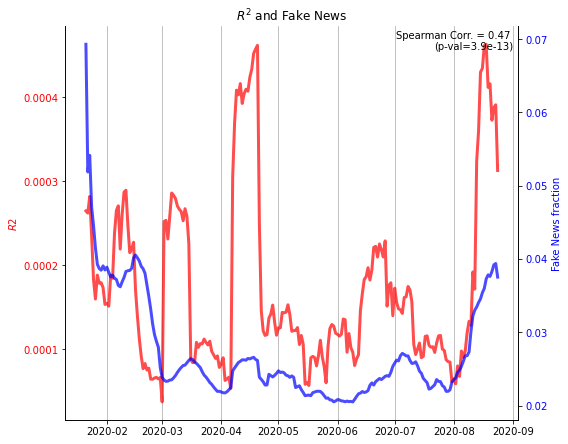

In [20]:
window = 14
tot_len = len(data_ff["n"])

fit_res_arr = []

for i in range(window,tot_len):
    tmp_y = np.log(1+data_ff["n"].values[i-window:i])
    tmp_x = np.log(1+data_ff[["n-1","s","s-1"]].values[i-window:i])
    fit_res = sm.OLS(tmp_y, tmp_x).fit()
#    fit_res_arr.append(fit_res.resid.mean()) ### ACCETTABILE (VECCHIO) pval issue
#    fit_res_arr.append(np.abs(fit_res.resid.mean()))### ACCETTABILE
#    fit_res_arr.append(np.abs(fit_res.resid/np.power(tmp_y,1)).mean()) ### FA PEGGIORARE IL FIT
#    fit_res_arr.append(np.abs(fit_res.resid/np.power(tmp_y,.5)).mean()) ### OTTIMO MA INSPIEGABILE
#    fit_res_arr.append((np.power(fit_res.resid,2)/tmp_y).mean()) ### OTTIMO MA INSPIEGABILE
    fit_res_arr.append((1-fit_res.rsquared)*tmp_y.mean()) ### OTTIMO MA INSPIEGABILE
df = pd.DataFrame(data={"R2":fit_res_arr})
df.index = data_ff.index[int(window/2):-1*int(window/2)]
df = df.dropna()
df = pd.concat([df,fdata[["fc/f","fc/c","fc/all"]].rolling(window,center=True).mean().dropna()],axis=1, join="inner").dropna()
df = df[df.index > "20-01-2020"]
spear_res = spearmanr(df["fc/c"],df["R2"])


fig, ax1 = plt.subplots(figsize=[8,6])
ax1.plot(df["R2"], color="red",lw=3,alpha=.7)
ax1.set_ylabel("$R2$", color="red" )
ax1.xaxis.grid(color="black",alpha=.3)
ax1.tick_params(axis='y', labelcolor="red")
ax2 = ax1.twinx() 
ax2.tick_params(axis='y', labelcolor="blue")
ax2.set_ylabel('Fake News fraction', color="blue" )
ax2.plot(df["fc/c"], color="blue",lw=3,alpha=.7, label='Fake News fraction')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("$R^2$ and Fake News")
sns.despine(fig=fig,right=False)

ax1.annotate("Spearman Corr. = %.2g \n(p-val=%.2g)" % spear_res, xy=(0.99, 0.99), xycoords="axes fraction",
            horizontalalignment='right', verticalalignment='top',)

plt.show()


### Loading and Normalizing News Related Queries Data

In [22]:
news_related = pd.read_pickle(base_path+"final_sep_queries_news/coronavirus&related.pickle").set_index("date")
news_rel_kw = [kw.split("_")[1] for kw in news_related.columns if kw[0] == "n"]
for kw in news_rel_kw:
    news_related["n_"+kw] /= news_related["count_article_each_date_coronavirus"]
normer_n = news_related["count_article_each_date_coronavirus"]
news_related = news_related.dropna()
news_related = news_related[["n_"+kw for kw in news_rel_kw if kw != "news"]]
news_related.columns = ["N" + c[1:] for c in news_related.columns]
news_rel_kw = [kw.split("_")[1] for kw in news_related.columns if kw[0] == "N"]
news_related = pd.concat([normer_n,news_related],axis=1).dropna()


### Loading and Normalizing Searches Related Queries Data

In [23]:
search_related = pd.read_csv(base_path+"/coronavirus_rq.csv",index_col=0)
search_rel_kw = [kw.split("_")[1] for kw in search_related.columns if kw[0] == "S"]
search_general = pd.read_csv(base_path+"interest_over_time_sep_queries.csv",index_col=0)
search_related["coronavirus"] = search_general["coronavirus"]
for kw in search_rel_kw:
    search_related["S_"+kw] /= search_related["coronavirus"]
search_related = search_related.dropna()
search_related = search_related[["S_"+kw for kw in search_rel_kw if kw != "news"]]
search_related["coronavirus"] = search_general["coronavirus"]

search_related.index = pd.to_datetime(search_related.index)
search_related.index = pd.DatetimeIndex(search_related.index,freq=search_related.index.inferred_freq)
search_rel_kw = [kw.split("_")[1] for kw in search_related.columns if kw[0] == "S"]


### Loading and Normalizing Fake News Data

In [24]:
fake_data = pd.read_pickle(base_path+"final_sep_queries_news/coronavirus&fake&related.pickle").set_index("date")
for kw in news_rel_kw:
    fake_data["n_"+kw] /= fake_data["count_article_each_date_coronavirus_fake"]
fake_normed = fake_data[["n_"+kw for kw in news_rel_kw if kw != "news"]].dropna()
fake_normed.columns = ["FN" + c[1:] for c in fake_normed.columns]


### Merging and Viz functions

In [25]:
data = pd.concat([search_related,news_related,fake_normed],axis=1).dropna()

In [26]:
def radarer(row):
    stats = np.log(row.values)
    labels = row.keys()
    angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)
    # close the plot
    pl_stats=np.concatenate((stats,[stats[0]]))
    pl_angles=np.concatenate((angles,[angles[0]]))
    fig=plt.figure()
    ax = fig.add_subplot(111, polar=True)
    ax.plot(pl_angles, pl_stats, 'o-', linewidth=2)
#    ax.fill(angles, stats, alpha=0.25)
    ax.set_thetagrids(angles * 180/np.pi, labels)
#    ax.grid(True)
    

In [27]:
sel_k_maj = {
    'italia': 'Italia',
    'lombardia':'Lombardia',
    'sintomi':'sintomi',
    'contagi':'contagi',
    'casi':'casi',
    'morti':'morti',
    'bollettino':'bollettino',
    'roma':'Roma',
    'dati':'dati',
    'mondo':'mondo',
    'mappa':'mappa',
    'sicilia':'Sicilia',
    'veneto':'Veneto',
    'campania':'Campania',
    'decreto':'decreto',
    'milano':'Milano',
    'piemonte':'Piemonte'}

### Semantics Overall Comparison


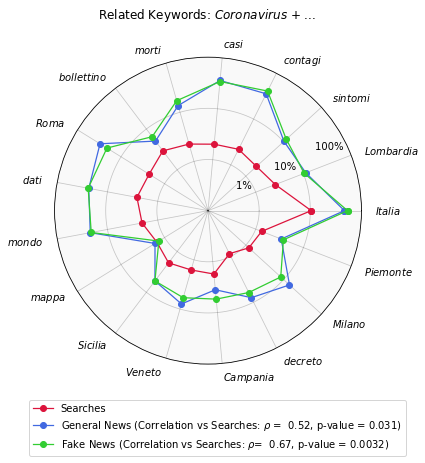

In [28]:
data_sum = data.mean()*100

fig = plt.figure(figsize=[6,8])
ax = fig.add_subplot(111, polar=True)

labels = search_rel_kw
angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)
pl_angles=np.concatenate((angles,[angles[0]]))

sstats = np.log10(data_sum[["S_"+kw for kw in search_rel_kw]].values)
pl_stats=np.concatenate((sstats,[sstats[0]]))
ax.plot(pl_angles, pl_stats, 'o-', linewidth=1.25,label="Searches", color="crimson")


nstats = np.log10(data_sum[["N_"+kw for kw in search_rel_kw]].values)
spear_res = spearmanr(sstats,nstats)
pl_stats=np.concatenate((nstats,[nstats[0]]))
ax.plot(pl_angles, pl_stats, 'o-', linewidth=1.25,label="General News (Correlation vs Searches: $ ρ $ =  %.2g, p-value = %.2g)"%spear_res, color="royalblue")

fnstats = np.log10(data_sum[["FN_"+kw for kw in search_rel_kw]].values)
spear_res = spearmanr(sstats,fnstats)
pl_stats=np.concatenate((fnstats,[fnstats[0]]))
ax.plot(pl_angles, pl_stats, 'o-', linewidth=1.25,label="Fake News (Correlation vs Searches: $ ρ $=  %.2g, p-value = %.2g)"%spear_res, color="limegreen")

ax.set_thetagrids(angles * 180/np.pi, labels=["$"+sel_k_maj[l]+"$" for l in labels])
ax.set_rgrids([-1,0,1,2],labels=["","1% ","10%  ","100%  "]*4,horizontalalignment='right')

for label, angle in zip(ax.get_xticklabels(), angles):
    if  np.pi/2 < angle < 3/2*np.pi:
        label.set_horizontalalignment('right')
    else:
        label.set_horizontalalignment('left')

ax.set_facecolor('#f9f9f9')
#ax.tick_params(axis='x', colors='#666')
#ax.grid(color="black", alpha=.3)

ax.grid(color="black", alpha=.2)

        
plt.legend(bbox_to_anchor=(-0.1, -.3, 0.3, 0.2), loc='upper left')
plt.title("Related Keywords: $Coronavirus$ + ... \n")
fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.savefig("radar.pdf")
plt.show()

In [29]:
trans = {'italia': "italy",
 'bollettino': "bulletin",
 'dati': "data",
 'lombardia': "lombardy",
 'roma': "rome",
 'morti': "deads",
 'contagi': "infections",
 'mondo': "world",
 'casi': "cases",
 'sintomi': "symptoms",
 'sicilia': "sicily",
 'campania': "campania",
 'veneto': "veneto",
 'mappa': "map",
 'piemonte': "piedmont",
 'milano': "milano",
 'decreto': "decree"}


In [30]:
test = dict(data_sum[["FN_"+kw for kw in search_rel_kw]])

s_list = list(dict(sorted(dict(data_sum[["S_"+kw for kw in search_rel_kw]]).items(), key=lambda item: item[1], reverse=True)).keys())
fn_list = list(dict(sorted(dict(data_sum[["FN_"+kw for kw in search_rel_kw]]).items(), key=lambda item: item[1], reverse=True)).keys())
n_list = list(dict(sorted(dict(data_sum[["N_"+kw for kw in search_rel_kw]]).items(), key=lambda item: item[1], reverse=True)).keys())

rank = {}
deltar_n = {}
deltar_fn = {}

for w in s_list:
    clean_w = w.split("_")[1]
    rank[clean_w]=[]
    rank[clean_w].append(-1*n_list.index("N_"+clean_w))
    rank[clean_w].append(-1*s_list.index(w))
    rank[clean_w].append(-1*fn_list.index("FN_"+clean_w))
    deltar_n[clean_w] = s_list.index(w)-n_list.index("N_"+clean_w)
    deltar_fn[clean_w] = s_list.index(w)-fn_list.index("FN_"+clean_w)
    

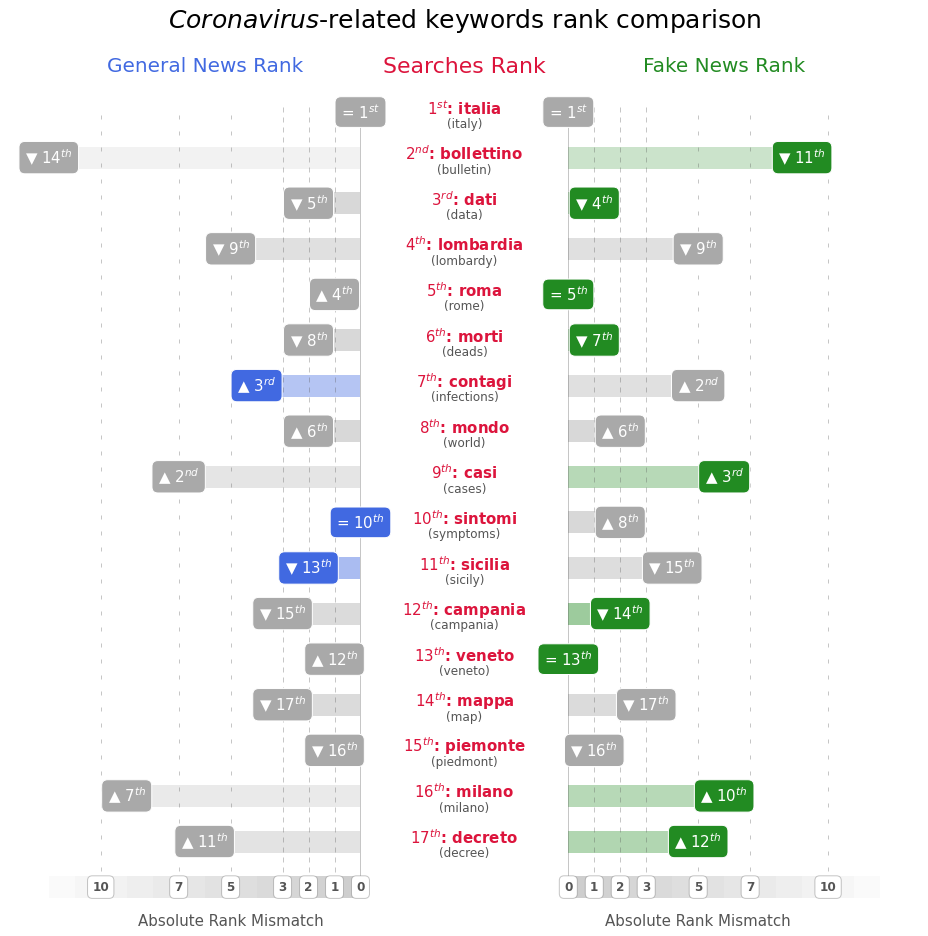

In [31]:
fig, ax = plt.subplots(figsize=[13,13])

ordi = ['$1^{st}$', '$2^{nd}$', '$3^{rd}$', '$4^{th}$', '$5^{th}$', '$6^{th}$', '$7^{th}$', '$8^{th}$', '$9^{th}$', '$10^{th}$',
 '$11^{th}$', '$12^{th}$', '$13^{th}$', '$14^{th}$', '$15^{th}$', '$16^{th}$', '$17^{th}$']

cmap = plt.cm.get_cmap('winter')

for e,w in enumerate(rank):
    this_x = (-np.abs(deltar_fn[w])+np.abs(deltar_n[w]))
    if deltar_fn[w]== 0:
        fn_suff = "="
    if deltar_fn[w]> 0:
        fn_suff = "▲"
    if deltar_fn[w]< 0:
        fn_suff = "▼"
    if deltar_n[w]== 0:
        n_suff = "="
    if deltar_n[w]> 0:
        n_suff = "▲"
    if deltar_n[w]< 0:
        n_suff = "▼"
        
    if np.abs(deltar_fn[w]) == np.abs(deltar_n[w]):
        l_c = fn_c = n_c = "darkgrey"
        fn_a = n_a =  .5- .5*np.abs(deltar_fn[w])/len(rank)
#        print(e,w,np.abs(deltar_fn[w])/len(rank))
    elif np.abs(deltar_fn[w]) < np.abs(deltar_n[w]):
        l_c = fn_c = "forestgreen"
        n_c = "darkgrey"
        fn_a = .5- .5*np.abs(deltar_fn[w])/len(rank)
        n_a =  .5- .5*np.abs(deltar_n[w])/len(rank)
    elif np.abs(deltar_fn[w]) > np.abs(deltar_n[w]):
        l_c = n_c = "royalblue"
        fn_c = "darkgrey"
        fn_a = .5- .5*np.abs(deltar_fn[w])/len(rank)
        n_a =  .5- .5*np.abs(deltar_n[w])/len(rank)
    plt.plot( [4,4+np.abs(deltar_fn[w])],[-e,-e],lw=22, c=fn_c,alpha=fn_a,solid_capstyle="butt")
    plt.plot( [-4,-4-np.abs(deltar_n[w])],[-e,-e],lw=22, c=n_c,alpha=n_a,solid_capstyle="butt")
#    plt.plot( [-3.5,+3.5],[-e,-e],lw=1, c="crimson",alpha=.33,solid_capstyle="butt")
    ax.text(0, -e-.1, ordi[e]+": "+w+"\n", ha="center", va="center", size=15, 
    bbox=dict(boxstyle="round,pad=.5",fc="#0000", ec="#0000"),color="crimson",weight="600")
    ax.text(0, -e-.1, "\n("+trans[w]+")", ha="center", va="center", size=12, 
    bbox=dict(boxstyle="round,pad=.3",fc="#0000", ec="#0000"),color="#555")
    ax.text(4+np.abs(deltar_fn[w]), -e, fn_suff +" "+ ordi[fn_list.index("FN_"+w)], ha="center", va="center", size=15, 
    bbox=dict(boxstyle="round,pad=.4", fc=fn_c, ec="white"),color="white")
    ax.text(-4-np.abs(deltar_n[w]), -e, n_suff+" "+ ordi[n_list.index("N_"+w)], ha="center", va="center", size=15, 
    bbox=dict(boxstyle="round,pad=.4", fc=n_c, ec="white"),color="white")
#plt.plot( [-2.5,+2.5],[-17,-17],lw=22, c="crimson",alpha=.2,solid_capstyle="butt")

for i in range(-16,-3):
    if i in [-4]:
        plt.plot([i,i], [-17,.1],lw=1,c="#5555")
        plt.plot([-i,-i], [-17,.1],lw=1,c="#5555")
    if i in [-5,-6,-7]:
        plt.plot([i,i], [-17,.1],lw=1,c="#5555",ls= (5, (5, 5)))
        plt.plot([-i,-i], [-17,.1],lw=1,c="#5555",ls= (5, (5, 5)))
    if i in [-9, -11,-14]:
        plt.plot([i,i], [-17,.1],lw=1,c="#5555",ls= (0, (4, 12)))
        plt.plot([-i,-i], [-17,.1],lw=1,c="#5555",ls= (0, (4, 12)))
    if i in [-4,-5,-6,-7,-9, -11,-14]:
        ax.text(i, -17, str(np.abs(i+4)), bbox=dict( boxstyle="round,pad=.4", fc="#fff", ec="#5555"),ha="center", va="center", size=12,color="#555", weight="bold")
        ax.text(-i, -17, str(np.abs(i+4)), bbox=dict( boxstyle="round,pad=.4", fc="#fff", ec="#5555"),ha="center", va="center", size=12,color="#555", weight="bold")

    plt.plot( [-4,i],[-17,-17],lw=22, c="black",alpha=.02,solid_capstyle="butt")
    plt.plot( [4,-i],[-17,-17],lw=22, c="black",alpha=.02,solid_capstyle="butt")
    
#plt.plot( [4.5,5.],[-17,-17],lw=22, c="black",alpha=.7,solid_capstyle="butt")

#    plt.scatter( [3+np.abs(deltar_fn[w])],[-e+.25],marker=fn_m,c=fn_c,s=fn_ms)
#    plt.scatter( [-3-np.abs(deltar_n[w])],[-e],marker=n_m,c=n_c,s=n_ms)
ax.text(0, 2, "$Coronavirus$-related keywords rank comparison", ha="center", va="center", size=25, bbox=dict(fc="#0000", ec="#0000"),color="black")
ax.text(0, 1, "Searches Rank", ha="center", va="center", size=22, bbox=dict(fc="#0000", ec="#0000"),color="crimson")
ax.text(-10, 1, "General News Rank", ha="center", va="center", size=20, bbox=dict(fc="#0000", ec="#0000"),color="royalblue")
ax.text(10, 1, "Fake News Rank", ha="center", va="center", size=20, bbox=dict(fc="#0000", ec="#0000"),color="forestgreen")
ax.text(9, -17.75, "Absolute Rank Mismatch", ha="center", va="center", size=15, bbox=dict(fc="#0000", ec="#0000"),color="#555")
ax.text(-9, -17.75, "Absolute Rank Mismatch", ha="center", va="center", size=15, bbox=dict(fc="#0000", ec="#0000"),color="#555")
#ax.arrow(-4, -17, -0.0001, 0, head_width=0.5, head_length=12.5, fc='#0007', ec='#0000')
#ax.arrow(4, -17, 0.0001, 0, head_width=0.5, head_length=12.5, fc='#0007', ec='#0000')
plt.axis('off')
fig.tight_layout()
plt.savefig("rank.pdf")

### Comparison in time

In [32]:
def sn(row):
    tmp_n = []
    tmp_s = []
    for kw in search_rel_kw:
        tmp_s.append(row["S_"+kw])
        tmp_n.append(row["N_"+kw])
    return distance.cosine(tmp_n,tmp_s)
def sfn(row):
    tmp_n = []
    tmp_s = []
    for kw in search_rel_kw:
        tmp_s.append(row["S_"+kw])
        tmp_n.append(row["FN_"+kw])
    return distance.cosine(tmp_n,tmp_s)
data["cd_SN"] = data.apply(sn, axis=1)
data["cd_SFN"] = data.apply(sfn, axis=1)

In [33]:
data = pd.concat([data,(fake_data["count_article_each_date_coronavirus_fake"]/fake_data["count_article_each_date_coronavirus"]).dropna()],axis=1,join="inner").rename(columns = {0:'fc/c'})
data = pd.concat([data,(fake_data["count_article_each_date_coronavirus_fake"]/fake_data["count_article_each_date_fake"]).dropna()],axis=1,join="inner").rename(columns = {0:'fc/f'})
data = pd.concat([data,(fake_data["count_article_each_date_fake"]/fake_data["count_article_each_date"]).dropna()],axis=1,join="inner").rename(columns = {0:'f/all'})


<ipython-input-34-7894b9f2564d>:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()  # otherwise the right y-label is slightly clipped


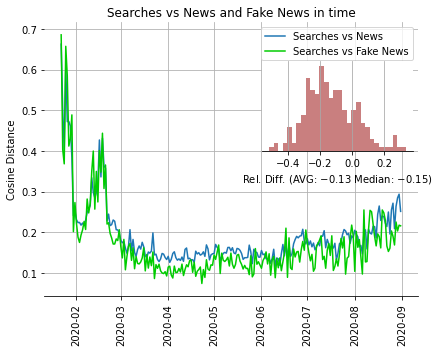

In [34]:
fig, ax1 = plt.subplots(figsize=[6,5])

ax1.plot(data["cd_SN"],label="Searches vs News")
ax1.plot(data["cd_SFN"],label="Searches vs Fake News",color=(0,.8,0))
#data["cd_SN"].plot(label="Searches vs News")
#data["cd_SFN"].plot(label="Searches vs Fake News",color=(0,.8,0))
#plt.ylim([0,.85])

left, bottom, width, height = [0.615, 0.5675, 0.35, 0.25]
ax2 = fig.add_axes([left, bottom, width, height])
((data["cd_SFN"]-data["cd_SN"])/data["cd_SN"]).hist(bins=30, density=True, alpha=.6, color="brown")
#ax2.
ax1.set_ylabel("Cosine Distance")
ax1.legend()
ax1.tick_params(axis='x', rotation=90)
ax1.grid()
ax2.grid(None)
ax2.set_yticks([])
ax2.grid(color="darkgray")
ax1.set_title("Searches vs News and Fake News in time")
ax2.set_xlabel("Rel. Diff. (AVG: $%.2g$ Median: $%.2g$)" % (((data["cd_SFN"]-data["cd_SN"])/data["cd_SN"]).mean(),((data["cd_SFN"]-data["cd_SN"])/data["cd_SN"]).median()))
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig("cosine.pdf")
sns.despine(left=True)

plt.show()

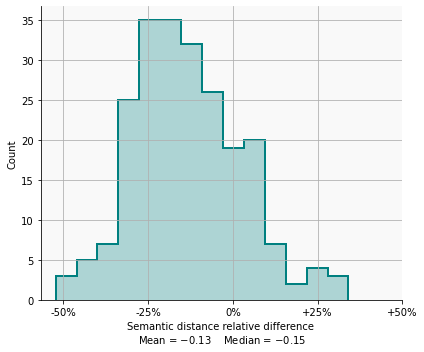

In [35]:
fig, ax1 = plt.subplots(figsize=[6,5])

plt.hist(((data["cd_SFN"]-data["cd_SN"])/data["cd_SN"]),bins=int(np.power(len(data["cd_SN"]),.5)),histtype='step', color="teal",lw = 2)
plt.hist(((data["cd_SFN"]-data["cd_SN"])/data["cd_SN"]),bins=int(np.power(len(data["cd_SN"]),.5)),histtype='stepfilled', alpha=.3, color="teal")
#ax2.
ax1.set_ylabel("Count")
#ax1.legend()
#ax1.tick_params(axis='x', rotation=90)
ax1.grid()
#ax2.grid(None)
ax1.set_xticks([-.5,-.25,0,.25,.5])
ax1.set_xticklabels(["-50%","-25%","0%","+25%","+50%"])
#ax2.grid(color="darkgray")
#ax1.set_title("Searches vs News and Fake News difference")
ax1.set_xlabel("Semantic distance relative difference \nMean = $%.2g$    Median = $%.2g$" % (((data["cd_SFN"]-data["cd_SN"])/data["cd_SN"]).mean(),((data["cd_SFN"]-data["cd_SN"])/data["cd_SN"]).median()))
fig.tight_layout()  # otherwise the right y-label is slightly clipped
sns.despine(left=False)
ax1.set_facecolor('#f9f9f9')
plt.savefig("cosine_hist.pdf")

plt.show()

### Misalignment and Fake News

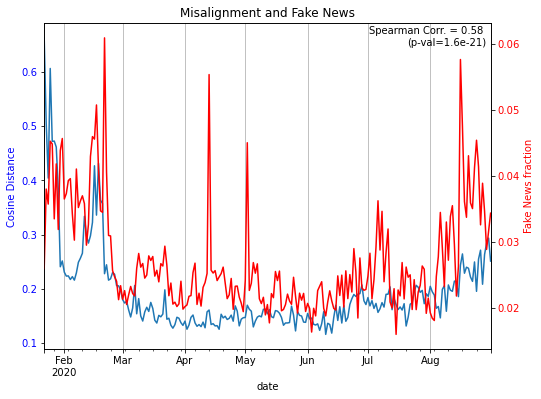

In [36]:
fig, ax1 = plt.subplots(figsize=[8,6])

ax1.set_ylabel("Cosine Distance", color="blue")
ax1.tick_params(axis='y', labelcolor="blue")

data["cd_SN"].plot()

ax2 = ax1.twinx() 

ax2.set_ylabel("Fake News fraction", color="red")
ax2.tick_params(axis='y', labelcolor="red")

data["fc/c"].plot(color="red")

ax1.annotate("Spearman Corr. = %.2g \n(p-val=%.2g)" % spearmanr(data["cd_SN"],data["fc/c"]), xy=(0.99, 0.99), xycoords="axes fraction",
            horizontalalignment='right', verticalalignment='top',)
ax1.xaxis.grid(color="black",alpha=.3)

plt.title("Misalignment and Fake News")
plt.show()

### Merging the indicators

In [37]:
df["CD_SN"] = data["cd_SN"].rolling(14,center=True).mean().dropna()
df["fc/c check"] = data["fc/c"].rolling(14,center=True).mean().dropna()
df = df.dropna()

#df["NORM_A"] = ((df["-Log(1-R2)"] - df["-Log(1-R2)"].mean())/df["-Log(1-R2)"].std())
#df["NORM_B"] = ((df["CD_SN"] - df["CD_SN"].mean())/df["CD_SN"].std())
#df["NORM_C"] = (df["fc/c"] - df["fc/c"].mean())/df["fc/c"].std()
#df["NORM_C"] = df["fc/c"]
df["NORM_A"] = np.log(1+df["R2"])
df["NORM_B"] = np.log(1+df["CD_SN"])
df["NORM_C"] = np.log(1+df["fc/c"])
df[["NORM_A","NORM_B","NORM_C"]].corr("spearman")


,NORM_A,NORM_B,NORM_C
NORM_A,1.000000,0.132337,0.442026
NORM_B,0.132337,1.000000,0.700953
NORM_C,0.442026,0.700953,1.000000


In [38]:
X = df[["NORM_A","NORM_B"]].values
y = df["NORM_C"].values
ols = sm.OLS(y, X)
ols_result = ols.fit()
print(ols_result.summary())


                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.994
Model:                            OLS   Adj. R-squared (uncentered):              0.994
Method:                 Least Squares   F-statistic:                          1.763e+04
Date:                Thu, 03 Jun 2021   Prob (F-statistic):                   6.14e-232
Time:                        15:48:28   Log-Likelihood:                          998.19
No. Observations:                 209   AIC:                                     -1992.
Df Residuals:                     207   BIC:                                     -1986.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

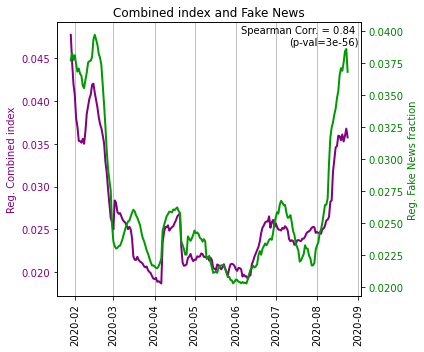

In [39]:
fig, ax1 = plt.subplots(figsize=[6,5])

ax1.set_ylabel("Reg. Combined index", color="purple")
ax1.tick_params(axis='y', labelcolor="purple")

ax1.plot(df["NORM_C"].index,ols_result.predict(X),color="purple",lw=2)

ax2 = ax1.twinx() 

ax2.set_ylabel("Reg. Fake News fraction",color=(0,.5,0))
ax2.tick_params(axis='y', labelcolor=(0,.5,0))

ax2.plot(df["NORM_C"].index,y,color=(0,.6,0),lw=2)

ax1.annotate("Spearman Corr. = %0.2f \n(p-val=%.2g)" % spearmanr(y,ols_result.predict(X)), xy=(0.99, 0.99), xycoords="axes fraction",
            horizontalalignment='right', verticalalignment='top',)
ax1.xaxis.grid(color="black",alpha=.3)
ax1.tick_params(axis='x', rotation=90)

plt.title("Combined index and Fake News")

fig.tight_layout()  # otherwise the right y-label is slightly clipped

#plt.savefig("index.pdf")

plt.show()




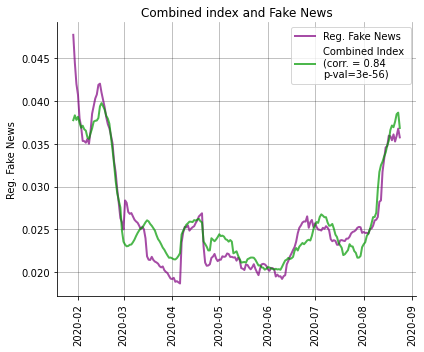

In [40]:
fig, ax1 = plt.subplots(figsize=[6,5])

ax1.set_ylabel("Reg. Fake News")

ax1.plot(df["NORM_C"].index,ols_result.predict(X),color="purple",lw=2, alpha=.7, label="Reg. Fake News")


#ax1.set_ylabel("Reg. Fake News fraction",color=(0,.5,0))
#ax2.tick_params(axis='y', labelcolor=(0,.5,0))

ax1.plot(df["NORM_C"].index,y,color=(0,.6,0),lw=2, alpha=.7, label="Combined Index \n(corr. = %0.2f \np-val=%.2g)" % spearmanr(y,ols_result.predict(X)))

#ax1.annotate("Spearman Corr. = %0.2f \n(p-val=%.2g)" % spearmanr(y,ols_result.predict(X)), xy=(0.99, 0.99), xycoords="axes fraction",
#            horizontalalignment='right', verticalalignment='top',)
ax1.xaxis.grid(color="black",alpha=.3)
ax1.yaxis.grid(color="black",alpha=.3)
ax1.tick_params(axis='x', rotation=90)

plt.title("Combined index and Fake News")

plt.legend()
fig.tight_layout()  # otherwise the right y-label is slightly clipped
sns.despine()
plt.savefig("index.pdf")

plt.show()




In [41]:
X = df[["NORM_A","NORM_B"]].values
y = df["NORM_C"].values
ols_tot = sm.OLS(y, X)
ols_result_tot = ols_tot.fit()
print(ols_result_tot.summary())


                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.994
Model:                            OLS   Adj. R-squared (uncentered):              0.994
Method:                 Least Squares   F-statistic:                          1.763e+04
Date:                Thu, 03 Jun 2021   Prob (F-statistic):                   6.14e-232
Time:                        15:48:31   Log-Likelihood:                          998.19
No. Observations:                 209   AIC:                                     -1992.
Df Residuals:                     207   BIC:                                     -1986.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

2020-01-29 00:00:00 2020-03-20 00:00:00
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.994
Model:                            OLS   Adj. R-squared (uncentered):              0.994
Method:                 Least Squares   F-statistic:                              3980.
Date:                Thu, 03 Jun 2021   Prob (F-statistic):                    5.92e-55
Time:                        15:48:37   Log-Likelihood:                          232.81
No. Observations:                  51   AIC:                                     -461.6
Df Residuals:                      49   BIC:                                     -457.8
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-

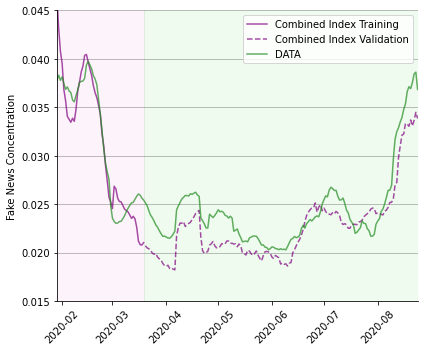

In [43]:
lim = 51
print(df["NORM_C"].index[0],df["NORM_C"].index[lim])
training_ols = sm.OLS(y[:lim], X[:lim])
training_ols_results = training_ols.fit()
print(training_ols_results.summary())
training = np.power(training_ols_results.predict(X)[:lim]-y[:lim],2)
validation = np.power(training_ols_results.predict(X)[lim:]-y[lim:],2)
var_est = np.sum(training)/training_ols_results.df_resid
print("stat = ",stats.chi2.sf(np.sum(validation)/(var_est),len(validation)))
print("training mean abs. rel. err. = ",np.mean(np.abs(training_ols_results.predict(X)[:lim]-y[:lim])/y[:lim]))
print("validation mean abs. rel. err. = ",np.mean(np.abs(training_ols_results.predict(X)[lim:]-y[lim:])/y[lim:]))

fig, ax1 = plt.subplots(figsize=[6,5])

dmin = df["NORM_C"].index[:lim].min()
dmid = df["NORM_C"].index[:lim].max()
dmax = df["NORM_C"].index.max()
ax1.fill([dmin,dmid,dmid,dmin], [0.0,0.0,0.05,0.05],c="C6", alpha=.08)
ax1.fill([dmid,dmax,dmax,dmid], [0.0,0.0,0.05,0.05],c="limegreen", alpha=.08)
#ax1.fill([dmin,dmid,dmid,dmin], [0.0,0.0,0.05,0.05],c="C6", alpha=.07)

ax1.set_ylabel("Fake News Concentration")

ax1.plot(df["NORM_C"].index[:lim],training_ols_results.predict(X)[:lim],color="purple",lw=1.5, alpha=.7, label="Combined Index Training")
ax1.plot(df["NORM_C"].index[lim:],training_ols_results.predict(X)[lim:],color="purple",ls="dashed",lw=1.5, label="Combined Index Validation", alpha=.7)
ax1.plot(df["NORM_C"].index,y,lw=1.5, color="forestgreen",alpha=.7, label="DATA")
#ax1.xaxis.grid(color="black",alpha=.3)
ax1.yaxis.grid(color="black",alpha=.3)
ax1.tick_params(axis='x', rotation=45)
#ax1.set_facecolor('#f9f9f9')

ax1.set_xlim([df["NORM_C"].index.min(),df["NORM_C"].index.max()])
ax1.set_ylim([0.015,.045])
#plt.title("Combined index and Fake News")

plt.legend()
fig.tight_layout()  # otherwise the right y-label is slightly clipped
sns.despine()
plt.savefig("index.pdf")

plt.show()




2020-01-29 00:00:00 2020-03-20 00:00:00
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.994
Model:                            OLS   Adj. R-squared (uncentered):              0.994
Method:                 Least Squares   F-statistic:                              3980.
Date:                Thu, 03 Jun 2021   Prob (F-statistic):                    5.92e-55
Time:                        15:49:11   Log-Likelihood:                          232.81
No. Observations:                  51   AIC:                                     -461.6
Df Residuals:                      49   BIC:                                     -457.8
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-

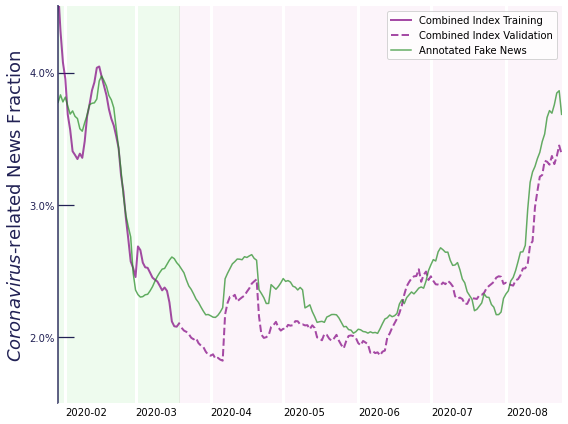

In [45]:
lim = 51
print(df["NORM_C"].index[0],df["NORM_C"].index[lim])
training_ols = sm.OLS(y[:lim], X[:lim])
training_ols_results = training_ols.fit()
print(training_ols_results.summary())
training = np.power(training_ols_results.predict(X)[:lim]-y[:lim],2)
validation = np.power(training_ols_results.predict(X)[lim:]-y[lim:],2)
var_est = np.sum(training)/training_ols_results.df_resid
print("stat = ",stats.chi2.sf(np.sum(validation)/(var_est),len(validation)))
print("training mean abs. rel. err. = ",np.mean(np.abs(training_ols_results.predict(X)[:lim]-y[:lim])/y[:lim]))
print("validation mean abs. rel. err. = ",np.mean(np.abs(training_ols_results.predict(X)[lim:]-y[lim:])/y[lim:]))

fig, ax1 = plt.subplots(figsize=[8,6])

dmin = df["NORM_C"].index[:lim].min()
dmid = df["NORM_C"].index[:lim].max()
dmax = df["NORM_C"].index.max()
ax1.fill([dmin,dmid,dmid,dmin], [0.0,0.0,0.05,0.05],c="limegreen", alpha=.08)
ax1.fill([dmid,dmax,dmax,dmid], [0.0,0.0,0.05,0.05],c="C6", alpha=.08)
#ax1.fill([dmin,dmid,dmid,dmin], [0.0,0.0,0.05,0.05],c="C6", alpha=.07)

ax1.plot(df["NORM_C"].index[:lim],training_ols_results.predict(X)[:lim],color="purple",lw=2, alpha=.7, label="Combined Index Training")
ax1.plot(df["NORM_C"].index[lim:],training_ols_results.predict(X)[lim:],color="purple",ls="dashed",lw=2, label="Combined Index Validation", alpha=.7)
ax1.plot(df["NORM_C"].index,y,lw=1.5, color="forestgreen",alpha=.7, label="Annotated Fake News")
#ax1.xaxis.grid(color="black",alpha=.3)
#ax1.yaxis.grid(color="white",lw=3)
ax1.tick_params(axis='x', rotation=0)
#ax1.set_facecolor('#f9f9f9')

ax1.set_xlim([df["NORM_C"].index.min(),df["NORM_C"].index.max()])
ax1.set_ylim([0.015,.045])
#plt.title("Combined index and Fake News")

yt = [.02,.03,.04]
ytl = ["%2.1f"%(100*f) + "%" for f in yt]


ax1.set(yticks=yt, yticklabels=ytl)

ax1.tick_params(direction='in', length=16,axis='y',width=1.25, color="#225")
ax1.grid(axis="x", color="#fff",lw=3)
#ax1.imshow([[1,-1],[1,-1]], cmap=plt.cm.bwr, interpolation='quadric', transform=ax1.transAxes, extent=[0,1,0.15,1], vmin=-5, vmax=5)


#ax1.set(xticklabels=xtl[1:])

for label in ax1.get_xticklabels():
    label.set_horizontalalignment('left')

ax1.tick_params(direction='inout', length=0, colors='black',axis='x',width=1.5)

ax1.set_ylabel('$Coronavirus$-related News Fraction', color="#225", fontsize=18)
ax1.tick_params(axis='y', labelcolor="#225")
ax1.spines['left'].set_color('#225')
ax1.spines['left'].set_linewidth(2)
ax1.spines['left'].set_alpha(.7)

ax1.spines['bottom'].set_color('white')

plt.legend()
fig.tight_layout()  # otherwise the right y-label is slightly clipped
sns.despine()
plt.savefig("img3.pdf")

plt.show()


